In [1]:
from functools import partial
import jax
from jax import grad, jit, lax, random, vmap
import jax.numpy as jnp
from jax.scipy.special import logit
import jax.scipy as scipy
import matplotlib.pyplot as plt

from jax.experimental.ode import odeint

In [2]:
plt.rcParams["figure.figsize"] = (16,10)
plt.rcParams["font.size"] = 24

In [157]:
SEED = 11 * 2 * 2021
key = random.PRNGKey(SEED)
key, subkey = random.split(key)

In [158]:

@jit
def SIR_step(u, t, θ):
    # Susceptible, Infectious wild type, Infectious variant, Recovered wild type, Recovered variant
    S, I_wt, I_v, R_wt, R_v, Inc_wt, Inc_v =  (u[0], u[1], u[2], u[3], u[4], u[5], u[6])

    # Transmissibility, recovery rate
    # eta_T is added variant transmissibility in susceptibles, 
    # eta_E is escape in recovered wt hosts
    # eta_gam is the ratio between recovery rates
    beta_wt, gam_wt, eta_T, eta_E, eta_gam  = (θ[0], θ[1], θ[2], θ[3], θ[4])
    
    lam_wt = beta_wt * S * I_wt # Wild-type transmission in naive
    lam_vs = (beta_wt * eta_T) * S * I_v # Variant transmission in naive
    lam_vr = (beta_wt * eta_T) * (eta_E * R_wt) * I_v # Variant transmission in wt recovered
    
    recov_wt = gam_wt * I_wt
    recov_v = gam_wt * eta_gam * I_v
    
    # Defining differential equations
    dS = -lam_wt - lam_vs
    dI_wt = lam_wt - recov_wt
    dI_v = lam_vs + lam_vr - recov_v
    dR_wt = recov_wt - lam_vr
    dR_v = recov_v
    
    # New compartments for capturing cummulative incidence
    dIncidence_wt = lam_wt
    dIncidence_v = lam_vs + lam_vr
    
    return jnp.stack([dS, dI_wt, dI_v, dR_wt, dR_v, dIncidence_wt, dIncidence_v])



## Analytic variant frequency SIR

We first consider the simple case where all variant advantage is derived from immunity.

We'll compare our simulated data to the analytic solution we dervied

$$
f_{v}(t) = \frac{f_v^0}{f_v^0 + f_{wt}^0 \exp\Big[(\beta_{wt} - \beta_{v}) \int_{0}^t S(\tau) d\tau\Big]}.
$$

Notice $\beta_{wt} - \beta_{v} = \beta_{wt} (1 - \eta_{T})$. 

In [182]:
# Defining model parameters
R0_wt = 1.4 # Basic reproduction number in wild type
R0_v = 1.9 # Basic reproduction number in variant

gen_wt = 3.8 # Average length of infection (days): 1 / gam_wt
gen_v = 3.8 # (...):  1 / gam_v
eta_E = 0. # Escape fraction

# Rest of quantities can be computed from the above
gam_wt =  1 / gen_wt
beta_wt = R0_wt * gam_wt

gam_v = 1 / gen_v
beta_v = R0_v * gam_v

eta_gam = gam_v / gam_wt
eta_T = beta_v / beta_wt

In [187]:
#  Defining parameters and initial conditions
true_θ = (beta_wt, gam_wt, eta_T, eta_E, eta_gam)

# Simulate
u0 = jnp.array([0.999, 0.002, 0.000001, 0.0, 0.0, 0.0, 0.0])
t = jnp.arange(100.)
Y = odeint(SIR_step, u0, t, true_θ)

In [188]:
S = jnp.append(0.0, Y[:, 0])
freq_v = jnp.divide(Y[:, 2][:,None], (Y[:,1] + Y[:,2])[:,None])

In [189]:
f0_w = u0[1] / (u0[1] + u0[2])
f0_v = 1 - f0_w
expect = f0_v / (f0_v + f0_w * jnp.exp((beta_wt - beta_v) * jnp.cumsum(S)))

Text(0, 0.5, 'Prevalence')

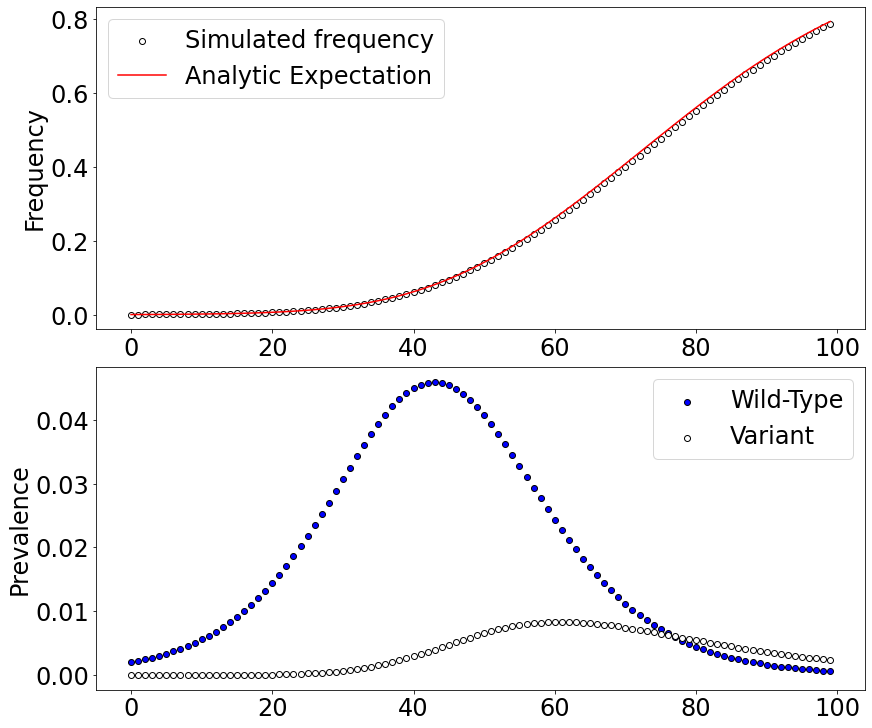

In [190]:
fig = plt.figure(figsize=(12., 10.), constrained_layout=True)
spec = fig.add_gridspec(ncols=1, nrows=2)

ax0 = fig.add_subplot(spec[0, 0])
ax0.scatter(t, freq_v, color = "white", ec="black", label="Simulated frequency")
ax0.plot(t, expect[:-1], color = "red", label="Analytic Expectation")
ax0.legend()
ax0.set_ylabel("Frequency")

ax0 = fig.add_subplot(spec[1, 0])
ax0.scatter(t, Y[:,1], color = "blue", ec="black", label="Wild-Type")
ax0.scatter(t, Y[:,2], color = "white", ec="black", label="Variant")

ax0.legend()
ax0.set_ylabel("Prevalence")

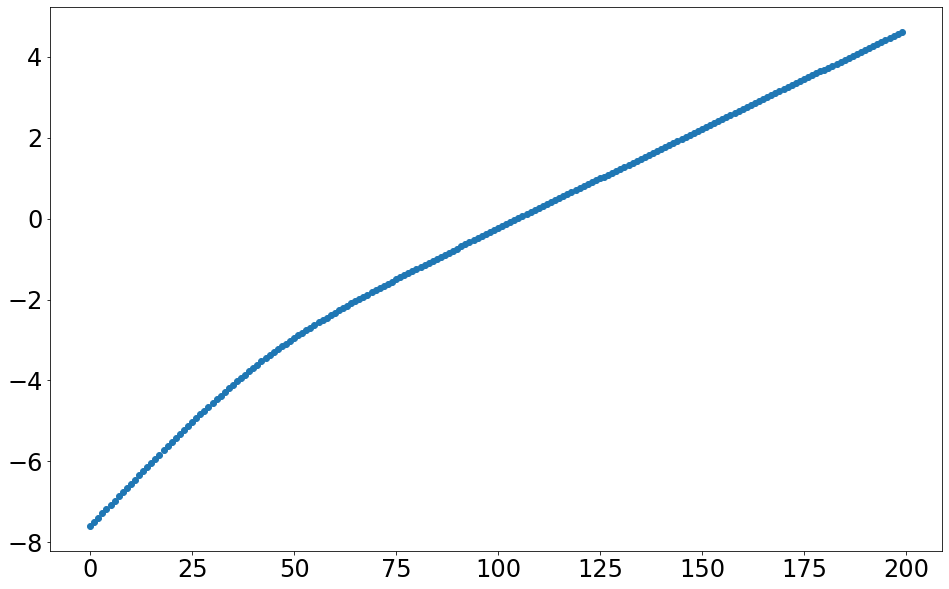

In [181]:
plt.scatter(t, logit(expect)[:-1]) # Logit of the frequency. This should be straight for MLR.

## Case with a single immune escaping variant

$$
f_{v}(t) = \frac{f_v^0}{f_v^0 + f_{wt}^0 \exp\Big[-\beta \eta_E \int_{0}^t \phi(\tau) d\tau\Big]}.
$$

In [166]:
# Defining model parameters
R0_wt = 1.9 # Basic reproduction number in wild type
R0_v = 1.9 # Basic reproduction number in variant

gen_wt = 3.8 # Average length of infection (days): 1 / gam_wt
gen_v = 3.8 # (...):  1 / gam_v
eta_E = 0.7 # Escape fraction

# Rest of quantities can be computed from the above
gam_wt =  1 / gen_wt
beta_wt = R0_wt * gam_wt

gam_v = 1 / gen_v
beta_v = R0_v * gam_v

eta_gam = gam_v / gam_wt
eta_T = beta_v / beta_wt

In [167]:
#  Defining parameters and initial conditions
true_θ = (beta_wt, gam_wt, eta_T, eta_E, eta_gam)

# Simulate
u0 = jnp.array([0.999, 0.001, 0.00001, 0.0, 0.0, 0.0, 0.0])
t = jnp.arange(100.)
Y = odeint(SIR_step, u0, t, true_θ)

In [168]:
freq_v = jnp.divide(Y[:, 2][:,None], (Y[:,1] + Y[:,2])[:,None])
phi = jnp.append(0.0, Y[:, 3])

In [169]:
f0_w = u0[1] / (u0[1] + u0[2])
f0_v = 1 - f0_w
expect = f0_v / (f0_v + f0_w * jnp.exp(- beta_wt * eta_E * jnp.cumsum(phi)))

Text(0, 0.5, 'Prevalence')

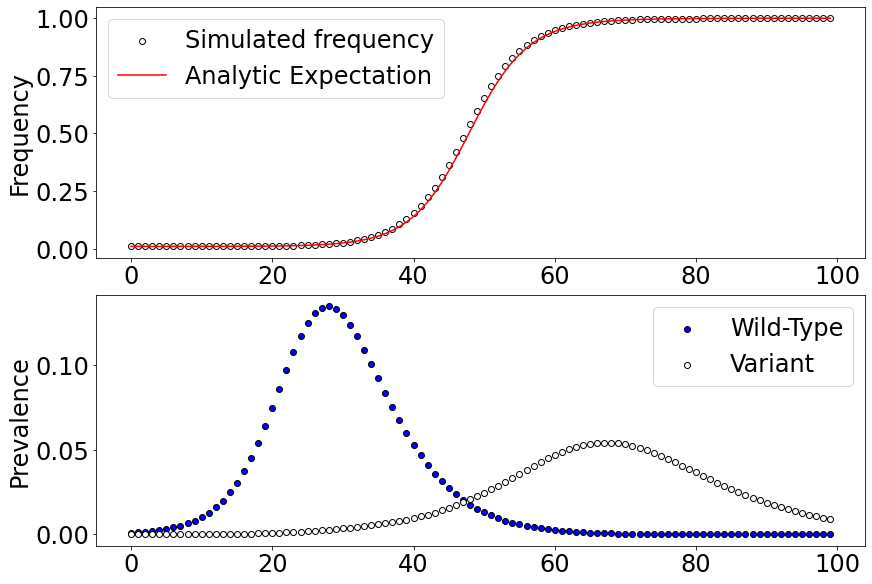

In [170]:
fig = plt.figure(figsize=(12., 8.), constrained_layout=True)
spec = fig.add_gridspec(ncols=1, nrows=2)

ax0 = fig.add_subplot(spec[0, 0])
ax0.scatter(t, freq_v, color = "white", ec="black", label="Simulated frequency")
ax0.plot(t, expect[:-1], color = "red", label="Analytic Expectation")
ax0.legend()
ax0.set_ylabel("Frequency")

ax0 = fig.add_subplot(spec[1, 0])
ax0.scatter(t, Y[:,1], color = "blue", ec="black", label="Wild-Type")
ax0.scatter(t, Y[:,2], color = "white", ec="black", label="Variant")

ax0.legend()
ax0.set_ylabel("Prevalence")

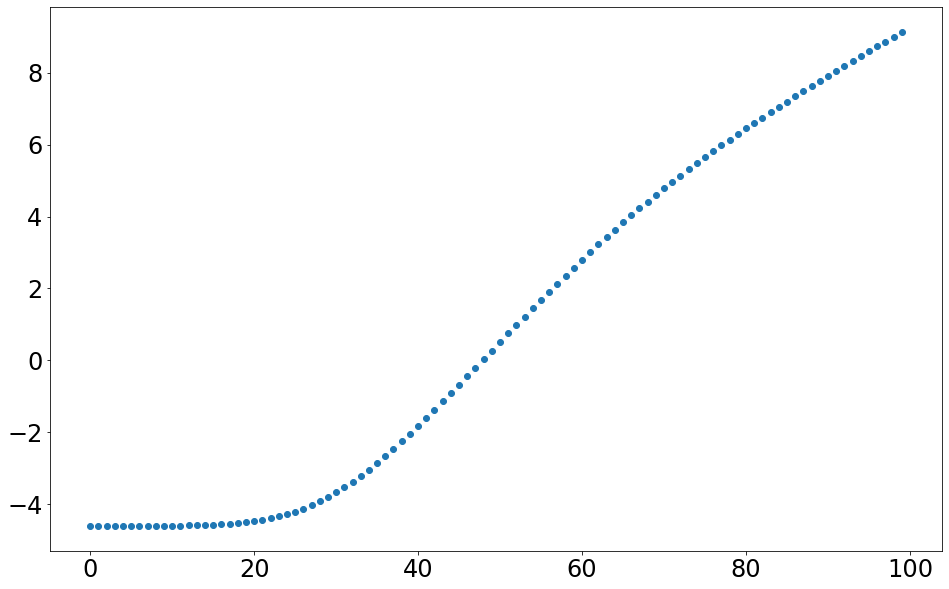

In [171]:
plt.scatter(t, logit(expect)[:-1]) # Logit of the frequency. This should be straight for MLR.

## Case with one immune escaping, one transmissibility increasing, one wild-type.

How is this going to work?

I can just use two-variant but include some prexisting immunity?

In [191]:

def SIR_var_step(u, t, θ):
    # Susceptible, Infectious wild type, Infectious variant, Recovered wild type, Recovered variant
    S, I_wt, I_ve, I_vt, R_wt, R_ve, R_vt, Inc_wt, Inc_ve, Inc_vt  = (u[0], u[1], u[2], u[3], u[4], u[5], u[6], u[7], u[8], u[9])

    # Transmissibility, recovery rate
    # eta_T is added variant transmissibility in susceptibles, 
    # eta_E is escape in recovered wt hosts
    beta_wt, gam_wt, eta_T, eta_E  = (θ[0], θ[1], θ[2], θ[3])
    
    lam_wt = beta_wt * S * I_wt # Wild-type transmission in naive
    lam_ves = beta_wt * S * I_ve # Variant transmission in naive
    lam_vts = (beta_wt * eta_T) * S * I_vt
    #lam_ver = beta_wt * (eta_E * R_wt) * I_ve # Variant transmission in wt recovered
    lam_ver = beta_wt * (eta_E * (R_wt + R_vt)) * I_ve # Variant transmission in wt recovered

    recov_wt = gam_wt * I_wt
    recov_ve = gam_wt * I_ve
    recov_vt = gam_wt * I_vt

    # Defining differential equations
    dS = - lam_wt - lam_ves - lam_vts
    
    dI_wt = lam_wt - recov_wt
    dI_ve = lam_ves - recov_ve + lam_ver 
    dI_vt = lam_vts - recov_vt
    
    dR_wt = recov_wt - lam_ver
    dR_ve = recov_ve
    dR_vt = recov_vt
    
    # New compartments for capturing cummulative incidence
    dInc_wt = lam_wt
    dInc_ve = lam_ves + lam_ver
    dInc_vt = lam_vts

    return jnp.stack([dS, dI_wt, dI_ve, dI_vt, dR_wt, dR_ve, dR_vt,  dInc_wt, dInc_ve, dInc_vt])

In [192]:
# Defining model parameters
R0_wt = 2.0 # Basic reproduction number in wild type
R0_vt = 2.5 # Basic reproduction number in more transmissible variant
R0_e = R0_wt # Basic reproduction number in escaping variant

gen = 3.8 # Average length of infection (days): 1 / gam_wt
eta_E = 0.6 # Escape fraction
S0 = 0.8 # Initial immunity

# Rest of quantities can be computed from the above
gam =  1 /  gen
beta_wt = R0_wt * gam
beta_vt = R0_vt * gam

eta_T = beta_vt / beta_wt

In [193]:
#  Defining parameters and initial conditions
true_θ = (beta_wt, gam, eta_T, eta_E)

# Simulate
u0 = jnp.array([S0, 0.001, 0.001, 0.001, 1-S0, 0.0, 0.0, 0.0, 0.0, 0.0])
t = jnp.arange(70.)
Y = odeint(SIR_var_step, u0, t, true_θ, mxstep=100)

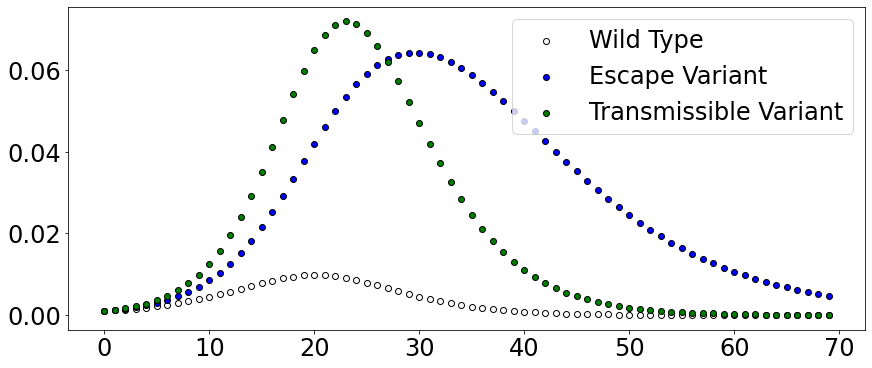

In [194]:
fig = plt.figure(figsize=(12., 5.), constrained_layout=True)
spec = fig.add_gridspec(ncols=1, nrows=1)

ax0 = fig.add_subplot(spec[0, 0])
ax0.scatter(t, Y[:,1], color = "white", ec="black", label="Wild Type")
ax0.scatter(t, Y[:,2], color = "blue", ec="black", label="Escape Variant")
ax0.scatter(t, Y[:,3], color = "green", ec="black", label="Transmissible Variant")

ax0.legend()

In [195]:
freq_ve = jnp.divide(Y[:, 2][:,None], (Y[:,1] + Y[:,2] + Y[:, 3])[:,None])
freq_vt = jnp.divide(Y[:, 3][:,None], (Y[:,1] + Y[:,2] + Y[:, 3])[:,None])

f0_w = u0[1] / (u0[1] + u0[2] + u0[3])
f0_ve = u0[2] / (u0[1] + u0[2] + u0[3])
f0_vt = u0[3] / (u0[1] + u0[2] + u0[3])

S = jnp.append(0.0, Y[:, 0])
phi = jnp.append(0.0, Y[:, 4]) +  jnp.append(0.0, Y[:, 6])

ve_comp = f0_ve * jnp.exp(beta_wt * eta_E * jnp.cumsum(phi))
w_comp = f0_w 
vt_comp = f0_vt * jnp.exp(beta_wt*(eta_T-1)*jnp.cumsum(S))
expect = ve_comp / (ve_comp + vt_comp + w_comp)

Text(0, 0.5, 'Logit Frequency')

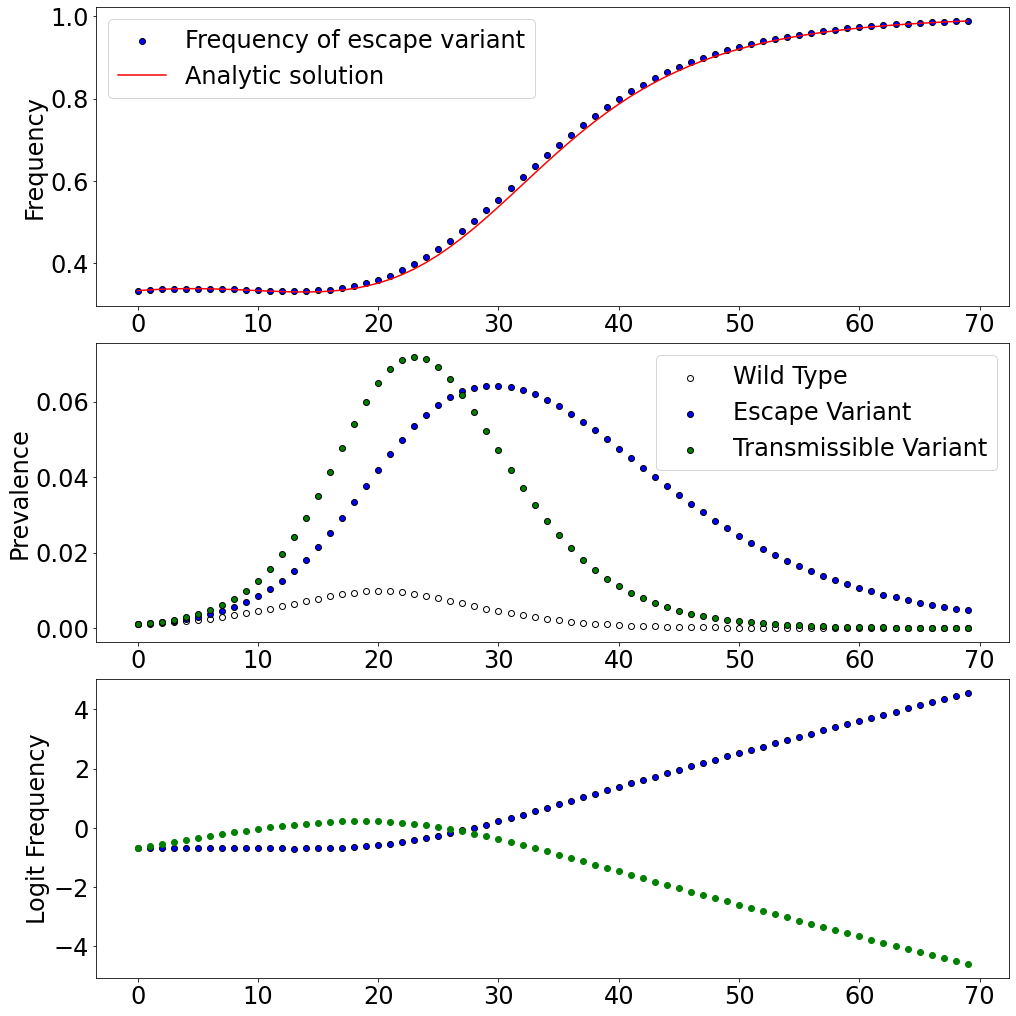

In [196]:
fig = plt.figure(figsize=(14., 14.), constrained_layout=True)
spec = fig.add_gridspec(ncols=1, nrows=3)

ax0 = fig.add_subplot(spec[0, 0])
ax0.scatter(t, freq_ve, color = "blue", ec="black", label="Frequency of escape variant")
ax0.plot(t, expect[:-1], color = "red", label="Analytic solution")
ax0.legend()
ax0.set_ylabel("Frequency")

ax0 = fig.add_subplot(spec[1, 0])
ax0.scatter(t, Y[:,1], color = "white", ec="black", label="Wild Type")
ax0.scatter(t, Y[:,2], color = "blue", ec="black", label="Escape Variant")
ax0.scatter(t, Y[:,3], color = "green", ec="black", label="Transmissible Variant")
ax0.legend()
ax0.set_ylabel("Prevalence")


ax0 = fig.add_subplot(spec[2, 0])
ax0.scatter(t, logit(freq_ve), color = "blue", ec="black", label="Frequency of escape variant")
ax0.scatter(t, logit(freq_vt), color = "green", label="Frequency of transmissible variant")
#ax0.legend()
ax0.set_ylabel("Logit Frequency")